### 3. EXPLORATORY DATA ANALYSIS

In this section I explore the distribution of garbage underlying cause codes by demographic characterisitics of the decedents as well as the county of death and the credentials of the medical certifiers who reported these causes of death.

In [1]:
import ast
import collections
from collections import Counter
import imp
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
ds =  pd.read_csv('Y:/DQSS/Death/MBG/py/capstone2/data/d1619_clean_preproctxt.csv',
                  low_memory=False,
                  encoding = 'unicode_escape')

In [3]:
len(ds)

7163

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [5]:
d = ds.copy()

In [6]:
d = pd.read_csv('Y:/DQSS/Death/MBG/py/capstone2/data/d1619_clean.csv',
                  low_memory=False,
                  encoding = 'unicode_escape')

In [7]:
d['Any_garbage_code'] = d['gc_cat'].apply(lambda x: 'No' if x==0 else 'Yes')

In [9]:
pd.crosstab(d.Any_garbage_code, d.dody, normalize='columns').round(3)*100

dody,2016,2017,2018,2019
Any_garbage_code,,,,
No,93.3,93.6,93.5,93.0
Yes,6.7,6.4,6.5,7.0


**There are 7,163 garbage coded records** out of a total of 226,997 death records.  These records have garbage codes (GC) as an underlying cause code but contain valid codes in multiple cause fields 2 through 20.

In [10]:
# create function to make barplots
def make_barplot_bygrp(x, hue, df, title):
    df=ds.loc[ds['gc_cat']!=0, :]
    percentage = lambda x: len(x)/float(len(df)) *100
    plt.figure(figsize=(9, 7))
    ax=sns.barplot(x=x, y=x, hue=hue, data= df, estimator=percentage, orient='h')
    ax.set(xlabel="Percent")
    ax.set(ylabel="GC category")
    ax.set(title = title)
    plt.show()    

**TYPES OF GARBAGE ICD-10 CODES** in the underlying cause of death field.

In [11]:
ds['gc_cat_label'].value_counts(normalize=True).round(3)*100

6-Ill-defined cardiovascular    34.0
1-Septicemia                    24.2
2-Heart failure                 20.9
3-Ill-defined cancer            20.3
5-Ill-defined                    0.5
Name: gc_cat_label, dtype: float64

In [12]:
ds['gc_cat_label'].value_counts()

6-Ill-defined cardiovascular    2439
1-Septicemia                    1733
2-Heart failure                 1499
3-Ill-defined cancer            1453
5-Ill-defined                     39
Name: gc_cat_label, dtype: int64

**5-Ill-defined conditions** - I started with 2,973 records that were labelled as 'ill-defined conditions' which is a catch-all category of garbage codes.  However, after removing all records which contained no codes in MC2 through MC20 (i.e. only one garbage code and no other cause of death information) I am left with only 39 records.  It would be interesting to look more closely at the age distribution for this group to understand whether older decedents are more affected by this problem.

In [13]:
ds= ds.loc[ds['gc_cat']!=5, :]
len(ds)

7124

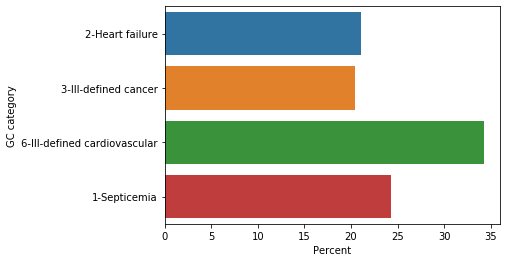

In [14]:
# frequency plot of records by garbage code category

ax=sns.barplot(x='gc_cat_label', y='gc_cat_label', data= ds, estimator=lambda x: len(x)/float(len(ds)) *100, orient='h')
ax.set(xlabel="Percent")
ax.set(ylabel="GC category")
plt.show()    

   Heart failure, ill-defined cancer, and ill-defined cardiovascular conditions (categories 2, 3, and 6 in the table above) together account for over half the roughly 15,000 records with garbage codes for this period. Undetermined intent and ill-defined infectious conditions (categories 8 and 9) are the categories with the fewest records. I will exclude categories with smaller numbers of records as the results may not be reliable.  

**Tobacco use contributing to death.**  Death registration in Washington State is entirely done electronically.  A drop down menu in death records requires that medical certifiers report whether tobacco use contributed to the death.  The response choices are:
- Y - yes
- P - probably
- N - no
- U - unknown

Initial analysis of ICD-10 frequency indicated that ICD-10 code F17.9  is present in 1,893 out of the 15,073 records i.e. in approximately 13% of the death records with garbage underlying cause codes. This is the code for "mental and behavioral disorders due to use of tobacco" and indicates that the medical certifier believed that tobacco use definitely or probably contributed to the death.  

In [15]:
ds['tobac'] = ds['tobac'].fillna('U')
ds['tobac'] = ds['tobac'].replace(['Y', 'P'], "Yes/Probably")
ds['tobac'] = ds['tobac'].replace(['N'], "No")
ds['tobac'] = ds['tobac'].replace(['U'], "Unknown")

In [16]:
ds.tobac.value_counts(dropna=False)

No              3555
Unknown         2301
Yes/Probably    1268
Name: tobac, dtype: int64

**A crosstabulation of tobacco use by garbage code** shows that in almost 20% of 'ill-defined cancer' deaths and 17% of ill-defined cardiovascualr deaths tobacco use was reported as definitely or probably a contributor to death.

In [17]:
round(pd.crosstab(ds.gc_cat_label, ds.tobac, normalize = "index")*100,1)

tobac,No,Unknown,Yes/Probably
gc_cat_label,,,
1-Septicemia,55.6,31.9,12.5
2-Heart failure,49.4,34.2,16.4
3-Ill-defined cancer,44.5,33.6,22.0
6-Ill-defined cardiovascular,49.4,30.7,19.9


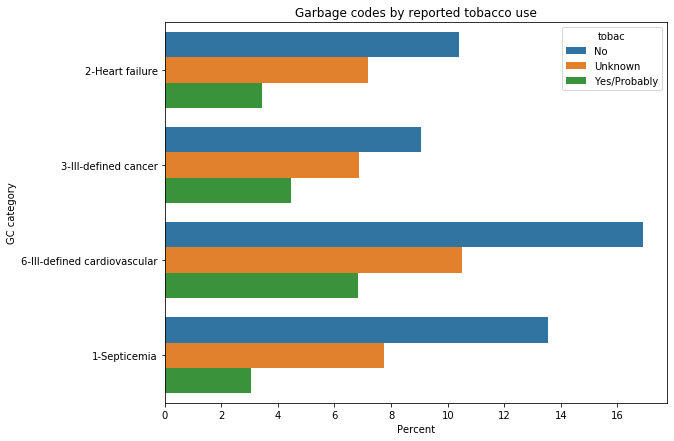

In [18]:
make_barplot_bygrp('gc_cat_label', 'tobac', ds, "Garbage codes by reported tobacco use")

**GC category by gender**

In [20]:
pd.crosstab(d.Any_garbage_code, d.sex, normalize='columns').round(3)*100

sex,F,M,U
Any_garbage_code,,,
No,93.1,93.6,75.0
Yes,6.9,6.4,25.0


In [21]:
round(pd.crosstab(ds['gc_cat_label'], ds['sex'], normalize ='index')*100,1), pd.crosstab(ds['gc_cat_label'], ds['sex'])

(sex                              F     M
 gc_cat_label                            
 1-Septicemia                  48.2  51.8
 2-Heart failure               51.5  48.5
 3-Ill-defined cancer          50.0  50.0
 6-Ill-defined cardiovascular  50.9  49.1,
 sex                              F     M
 gc_cat_label                            
 1-Septicemia                   836   897
 2-Heart failure                772   727
 3-Ill-defined cancer           727   726
 6-Ill-defined cardiovascular  1242  1197)

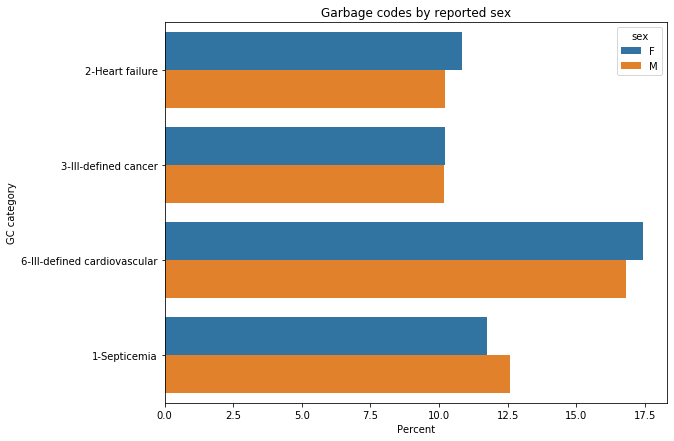

In [22]:
make_barplot_bygrp('gc_cat_label', 'sex', ds, "Garbage codes by reported sex")

The first table indicates that both male and female decedents had the same proportions of records that had garbage underlying cause codes. 

Crosstabulation of each category by gender shows that women are more likely to have garbage codes related to 2-Heart failure, 4-Volume depletion, and 6-Ill-defined cardiovascular.  Men are more likely to receive an undetermined intent code.

**GC category by age group**

In [23]:
# Proportion of all death records with garbage codes by age agroup (percent)
pd.crosstab(d.Any_garbage_code, d.agegrp, normalize='columns').round(3)*100

agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
Any_garbage_code,,,,,,,,
No,94.7,94.1,94.2,93.9,93.7,93.7,93.6,93.0
Yes,5.3,5.9,5.8,6.1,6.3,6.3,6.4,7.0


In [24]:
pd.crosstab(d.Any_garbage_code, d.agegrp)

agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
Any_garbage_code,,,,,,,,
No,1438,3256,4678,7500,18498,35186,45630,94506
Yes,80,205,286,486,1249,2374,3099,7064


In [25]:
# Distribution of GC codes by GC category and age group - row percentages
round(pd.crosstab(ds['gc_cat_label'], ds['agegrp'], normalize="columns"), 3)*100


agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
gc_cat_label,,,,,,,,
1-Septicemia,38.5,39.4,38.5,29.4,26.3,27.6,26.8,20.8
2-Heart failure,0.0,3.0,7.7,7.2,12.1,11.7,17.3,28.8
3-Ill-defined cancer,23.1,12.1,21.8,23.3,21.2,27.7,24.1,16.0
6-Ill-defined cardiovascular,38.5,45.5,32.1,40.0,40.4,32.9,31.8,34.5


In [26]:
pd.crosstab(ds['gc_cat_label'], ds['agegrp'])

agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
gc_cat_label,,,,,,,,
1-Septicemia,5,13,30,53,150,328,428,721
2-Heart failure,0,1,6,13,69,139,276,995
3-Ill-defined cancer,3,4,17,42,121,329,385,552
6-Ill-defined cardiovascular,5,15,25,72,230,391,507,1192


The proportion of records with garbage underlying codes increases with age acounting for about 5.3% of death records for 1-19 year olds and about 7% of records for decedents who were 80 years or older.

Ill-defined cardiovascular disease accounts for the greatest proportion of GC underlying cause codes for decedents who were 50 years and older. For decedents below the age of 50 years the catch all 'ill-defined other' category accounted for the greatest proportion of GC deaths. Ill defined (other) and undetermined intent accounted for most of the GC underlying cause codes among decedents aged 0 to 19 years.  Ill-defined infectious diseases were the least common type of GC underlying cause code across all age groups.

**GC category by race**

In [27]:
# Proportion of all death records with garbage codes by race (percent)
pd.crosstab(d.Any_garbage_code, d.race, normalize='columns').round(3)*100

race,AIAN,African Am.,Asian,Other/multirace,Pacific Isl.,Unknown,White
Any_garbage_code,,,,,,,
No,92.1,92.9,93.7,93.5,93.8,93.7,93.4
Yes,7.9,7.1,6.3,6.5,6.2,6.3,6.6


In [28]:
pd.crosstab(d.Any_garbage_code, d.race)

race,AIAN,African Am.,Asian,Other/multirace,Pacific Isl.,Unknown,White
Any_garbage_code,,,,,,,
No,3217,6287,8620,6150,1190,682,185778
Yes,276,478,578,427,79,46,13189


In [29]:
# Distribution of GC categories by race - 
pd.crosstab(ds['gc_cat_label'], ds['race'], normalize="columns").round(3)*100

race,AIAN,African Am.,Asian,Other/multirace,Pacific Isl.,Unknown,White
gc_cat_label,,,,,,,
1-Septicemia,42.5,25.7,23.3,30.5,38.3,22.2,23.7
2-Heart failure,14.2,14.9,19.7,18.0,27.7,27.8,21.5
3-Ill-defined cancer,13.2,16.6,23.3,21.0,6.4,22.2,20.6
6-Ill-defined cardiovascular,30.2,42.7,33.7,30.5,27.7,27.8,34.2


In [30]:
# Distribution of GC categories by race - counts
pd.crosstab(ds['gc_cat_label'], ds['race'])

race,AIAN,African Am.,Asian,Other/multirace,Pacific Isl.,Unknown,White
gc_cat_label,,,,,,,
1-Septicemia,45,62,70,51,18,4,1483
2-Heart failure,15,36,59,30,13,5,1341
3-Ill-defined cancer,14,40,70,35,3,4,1287
6-Ill-defined cardiovascular,32,103,101,51,13,5,2134


Almost 8% of death records for AIAN non-Hispanic decedents had garbage underlying cause codes compared with white non-Hispanic or Asian non-Hispanic decedents for whom about 6.6% and 6.3% (respectively) of records had these problems.  Adding to this problem is the fact that AIAN decedents are undercounted in Washington State as they are reported as other races on the death records.

Other ill-defined conditions accounted for almost 38% of the GC underlying cause codes among American Indian/Alaska Native decedents and about 33% of multi-racial decedents.  In comparison this category accounted for only 14% of GC underlying cause codes among Asian decedents. Among White decedents the largest category of GC deaths accounting for almost 26% of records with garbage underlying cause codes was ill-defined cardiovascular disease.This was also true for African American decedents; over 32% of death records with garbage underlying cause codes fell into the ill-defined cardiovascular disease category.

**GC category by ethnicity**

In [31]:
pd.crosstab(d.Any_garbage_code, d.hispanic, normalize='columns').round(3)*100

hispanic,No,Yes
Any_garbage_code,,
No,93.4,92.7
Yes,6.6,7.3


In [32]:
pd.crosstab(d.Any_garbage_code, d.hispanic)

hispanic,No,Yes
Any_garbage_code,,
No,204107,7817
Yes,14461,612


In [33]:
# Distribution of GC categories by ethnicity - counts
pd.crosstab(ds['gc_cat_label'], ds['hispanic'], normalize="columns").round(3)*100

hispanic,No,Yes
gc_cat_label,,
1-Septicemia,24.0,34.8
2-Heart failure,21.2,15.9
3-Ill-defined cancer,20.4,19.4
6-Ill-defined cardiovascular,34.4,30.0


In [34]:
# Distribution of GC categories by ethnicity- counts
pd.crosstab(ds['gc_cat_label'], ds['hispanic'])

hispanic,No,Yes
gc_cat_label,,
1-Septicemia,1654,79
2-Heart failure,1463,36
3-Ill-defined cancer,1409,44
6-Ill-defined cardiovascular,2371,68


The proportion of death records for Hispanic decedents that had garbage underlying cause codes was slightly higher than for (7.3% vs. 6.6%).

For Hispanic decedents, other ill-defined conditions and ill-defined cardiovascular disease accounted for half the garbage underlying cause codes.

**GC category by death county**

This table shows the distribution of garbage code categories within each county. In most counties, ill-defined cardiovascular and heart failure together account for the greatest proportion of garbage codes in each county, often accounting for over half the deaths with garbage underlying cause codes.

In [35]:
# Distribution of GC categories by county - row percentages
pd.crosstab(ds['dcounty'], ds['gc_cat_label'], normalize='index').round(3)*100

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,6-Ill-defined cardiovascular
dcounty,,,,
ADAMS,25.0,12.5,12.5,50.0
ASOTIN,25.9,33.3,14.8,25.9
BENTON,31.6,11.7,20.4,36.4
CHELAN,16.2,17.9,31.6,34.2
CLALLAM,20.7,25.0,18.5,35.9
CLARK,22.2,20.7,25.6,31.6
COLUMBIA,0.0,0.0,20.0,80.0
COWLITZ,32.7,27.4,20.2,19.6
DOUGLAS,8.3,29.2,50.0,12.5


In [36]:
# Distribution of GC categories by county - counts
pd.crosstab(ds['dcounty'], ds['gc_cat_label'])

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,6-Ill-defined cardiovascular
dcounty,,,,
ADAMS,2,1,1,4
ASOTIN,7,9,4,7
BENTON,65,24,42,75
CHELAN,19,21,37,40
CLALLAM,19,23,17,33
CLARK,104,97,120,148
COLUMBIA,0,0,1,4
COWLITZ,55,46,34,33
DOUGLAS,2,7,12,3


The tendency toward assigning an ill-defined cardiovascular disease code or other ill-defined condition code is apparent across most counties.

**GC category by medical certifier types**

In [37]:
pd.crosstab(d.Any_garbage_code, d.cert_label, normalize='columns').round(3)*100

cert_label,1-Physician,2-ME/Coroner,3-DO,4-Chiropractor,6-PA,7-ARNP,8-NA,9-Unknown
Any_garbage_code,,,,,,,,
No,93.7,92.2,93.2,100.0,90.6,93.6,100.0,93.7
Yes,6.3,7.8,6.8,0.0,9.4,6.4,0.0,6.3


In [38]:
pd.crosstab(d.Any_garbage_code, d.cert_label)

cert_label,1-Physician,2-ME/Coroner,3-DO,4-Chiropractor,6-PA,7-ARNP,8-NA,9-Unknown
Any_garbage_code,,,,,,,,
No,140928,32324,10924,3,4074,22146,2,1523
Yes,9479,2749,800,0,421,1522,0,102


In [39]:
#GC category by medical certifier type - column percentages
pd.crosstab(ds['cert_label'],ds['gc_cat_label'], normalize="columns").round(3)*100

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,6-Ill-defined cardiovascular
cert_label,,,,
1-Physician,79.1,70.6,75.4,64.2
2-ME/Coroner,3.1,4.3,2.3,15.5
3-DO,6.6,6.9,6.6,5.6
6-PA,2.7,3.7,2.8,2.9
7-ARNP,7.6,13.4,12.7,11.2
9-Unknown,0.9,1.0,0.3,0.6


In [40]:
pd.crosstab(ds['cert_label'],ds['gc_cat_label'])

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,6-Ill-defined cardiovascular
cert_label,,,,
1-Physician,1371,1059,1095,1566
2-ME/Coroner,53,64,33,379
3-DO,115,104,96,136
6-PA,47,56,40,71
7-ARNP,132,201,184,272
9-Unknown,15,15,5,15


As a percentage of their own group, physician's assistants (PAs) generated the highest proportion of garbage codes compared with other certifier types.  While almost 9.5% of death records certified by PAs had garbage codes as underlying causes 6.3% of records certified by physicians and 6.4% of nurse practitioners (ARNPs) suffered the same problem.

As physicians are the largest group of cause of death certifiers, it is no surprise that the largest proportion of most GC categories are attributable to them. One exception is other ill-defined conditions. Medical examiners and coroners contribute the most to this type of GC underlying cause code.
<br> 
<br> 

**BAG OF WORDS ANALYSIS**

As stated in the introduction, I chose to use ICD-10 codes for natural language processing (NLP) rather than the cause of death literal text because of the inherent advantages the coding system presents. The rest of this section examines the frequency of various cause of death codes in multiple cause 1 through multiple cause 20 fields.
<br> 
<br>

In [41]:
len(ds)

7124

The data set is further reduced to 7,24 records after I removed records that had empty cells in the 'clean_mc' variable.  This variable was created by removing all GC codes from both the underlying cause code and all multiple cause codes. This indicates that roughly half of the records with garbage underlying cause codes had no other valid codes in their causes of death.

In [49]:
ds.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label,clean_mc,short_mc,clean_mcgc,all_bigrams,mc2_20_short_toks
0,2017025200,F,2017,SNOHOMISH,No,White,80+ yrs,N,No,8.0,2,2-Heart failure,I500,D469,I500 D469 I802 J189 T828 Y831,D469 I802 J189 T828 Y831,"CONGESTIVE HEART FAILURE, CAUSE NOT FORMALLY W...",1-Physician,"['D469', 'I802', 'J189', 'Y831']","['D46', 'I80', 'J18', 'Y83']","['I50', 'D46', 'I80', 'J18', 'T82', 'Y83']","['D469_I802', 'I802_J189', 'J189_Y831']","['D46', 'I80', 'J18', 'T82', 'Y83']"
1,2018031044,M,2018,PIERCE,No,White,60-69 yrs,N,Unknown,8.0,3,3-Ill-defined cancer,C80,B182,C80 B182 C786 N179,B182 C786 N179,METASTATIC MALIGNANCY WITH PERITONEAL CARCINOM...,7-ARNP,"['B182', 'C786', 'N179']","['B18', 'C78', 'N17']","['C80', 'B18', 'C78', 'N17']","['B182_C786', 'C786_N179']","['B18', 'C78', 'N17']"
2,2017019359,F,2017,PIERCE,No,White,80+ yrs,N,Yes/Probably,8.0,2,2-Heart failure,I509,A310,I509 A310 F179 I120 I461 I48 J449 K922 Q600 ...,A310 F179 I120 I461 I48 J449 K922 Q600,"SUDDEN CARDIAC DEATH, PROBABLE ARRHYTHMIA ATRI...",1-Physician,"['A310', 'I120', 'I48', 'J449', 'K922', 'Q600']","['A31', 'I12', 'I48', 'J44', 'K92', 'Q60']","['I50', 'A31', 'F17', 'I12', 'I46', 'I48', 'J4...","['A310_I120', 'I120_I48', 'I48_J449', 'J449_K9...","['A31', 'F17', 'I12', 'I46', 'I48', 'J44', 'K9..."
3,2017026057,F,2017,CLALLAM,No,White,80+ yrs,N,No,8.0,2,2-Heart failure,I500,F03,I500 F03 J189,F03 J189,PNEUMONIA SYSTOLIC CONGESTIVE HEART FAILURE ...,1-Physician,"['F03', 'J189']","['F03', 'J18']","['I50', 'F03', 'J18']",['F03_J189'],"['F03', 'J18']"
4,2017022720,F,2017,KING,No,White,80+ yrs,N,No,8.0,6,6-Ill-defined cardiovascular,I10,I48,I10 I48,I48,"UNSPECIFIED NATURAL CAUSES HYPERTENSION, AT...",1-Physician,['I48'],['I48'],"['I10', 'I48']",[],['I48']


In [42]:
mc_gc_list = [a for b in ds['clean_mcgc'] for a in ast.literal_eval(b)]
mc_list = [a for b in ds['short_mc'] for a in ast.literal_eval(b)]
mc_bigram = [a for b in ds['all_bigrams'] for a in ast.literal_eval(b)]

In [43]:
## function to create bag of word most common words and plot

def create_bow_plot(tokens_list, title):
    bow = Counter(tokens_list)
    top20=bow.most_common(20)
    print('***' + title + '***')
    print("Twenty most common ICD-10 codes:")
    print(top20)
    top20df=pd.DataFrame(top20, columns=['Code', 'Count'])
    plt.figure(figsize=(9, 7))
    plt.bar(top20df['Code'], top20df['Count'])
    plt.title("Bag of words - " + title)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    

***ICD-10 SHORT CODES INCLUDING GCs***
Twenty most common ICD-10 codes:
[('I50', 2075), ('A41', 1954), ('I10', 1631), ('J96', 1466), ('C80', 1370), ('F17', 1270), ('I46', 1137), ('I48', 820), ('J44', 712), ('C78', 644), ('J18', 592), ('N17', 562), ('I51', 528), ('N18', 509), ('E14', 487), ('I26', 472), ('A49', 459), ('F03', 451), ('C79', 445), ('I70', 401)]


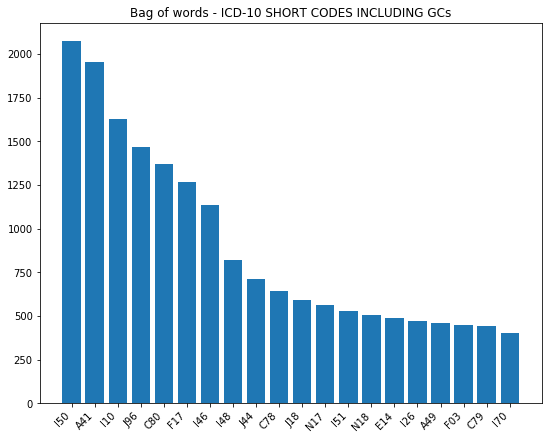

In [44]:
create_bow_plot(mc_gc_list, "ICD-10 SHORT CODES INCLUDING GCs")

**With GCs in the corpus** the three most common ICD-10 codes are I50 (congestive heart failure), A41 (sepsis due to bacterial infections), and I10 (essential hypertension).

***ICD-10 SHORT CODES EXCLUDING GCs***
Twenty most common ICD-10 codes:
[('I48', 820), ('J44', 712), ('C78', 644), ('J18', 592), ('N17', 562), ('N18', 509), ('E14', 487), ('A49', 459), ('F03', 451), ('C79', 445), ('E78', 366), ('E11', 362), ('G93', 345), ('F01', 282), ('N28', 269), ('I25', 261), ('E66', 257), ('G30', 220), ('J69', 210), ('N19', 194)]


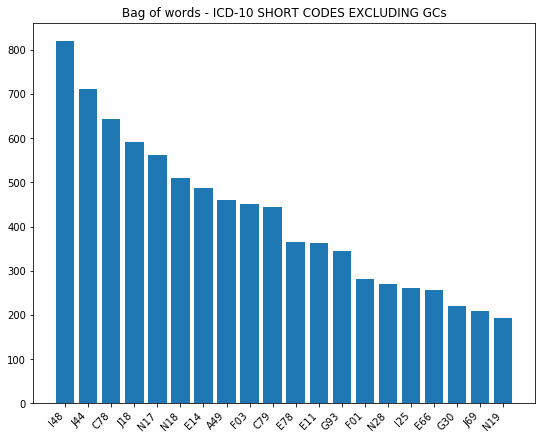

In [45]:
create_bow_plot(mc_list, "ICD-10 SHORT CODES EXCLUDING RECORDS WITH GCs AS UNDERLYING CAUSE CODES")

**After removing GCs from the corpus** the most three common ICD-10 codes are I48 (atrial fibrillation), J44 (COPD), and N17 (acute renal failure).

The following codes also dominate the category-specific bags of words plots:

- J96.0 - Acute respiratory failure
- J96.9 - Respiratory failure unspecified
- J18.9 - Pneumonia
- J44.9 - Chronic obstructive pulmonary disease
- N17.9 - Acute renal failure
- F17.9 - Mental and behavioral disorders due to use of tobacco
- C78.7 - Secondary malignant neoplasm of liver and intrahepatic bile duct
- C78.0 - Secondary malignant neoplasm of lung 
- C79.5 - Secondary malignant neoplasm of bone and bone marrow
- C79.8 - Secondary malignant neoplasm of other specified sites
- I48   - Atrial fibrillation
- E78.5 - Hyperlipidemia, unspecified


***ICD-10 BIGRAMS EXCLUDING GCs***
Twenty most common ICD-10 codes:
[('N179_N189', 67), ('I48_J449', 66), ('C780_C787', 63), ('I48_J189', 44), ('J189_N179', 42), ('F03_I48', 40), ('C787_C795', 39), ('I251_I48', 37), ('E149_E785', 36), ('I48_I64', 35), ('J189_J80', 31), ('C787_C788', 28), ('E119_E785', 27), ('E785_F019', 26), ('F019_I48', 26), ('F03_J189', 24), ('E149_E669', 23), ('C795_C798', 23), ('C780_C798', 22), ('J189_J90', 22)]


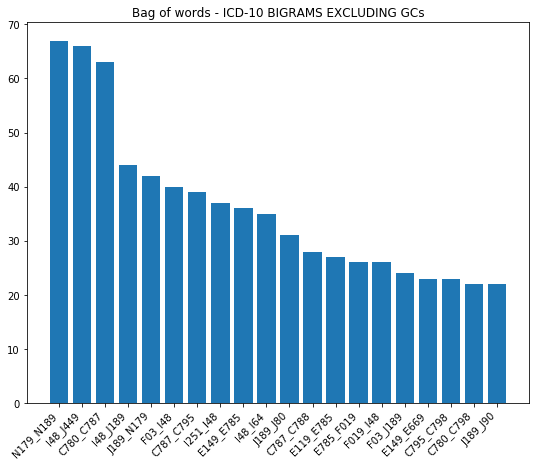

In [46]:
create_bow_plot(mc_bigram, "ICD-10 BIGRAMS EXCLUDING GCs")

Bigrams of adjacent ICD-10 codes provide an added level of detail by providing context to each code.  The most common bigram is N17.9-N718.9 which are acute renal failure and chronic kidney disease unspecified.  The next most common bigrams are I48-J44.9 (atrial fibrillation and COPD) and C78.0-C78.7 (secondary malignant neoplasm of lung and secondary malignant neoplasm of liver. These codes already provide some indication of the cause of death categories to which these records might be reassigned.

**Create bag of words for each garbage code category**

In the following section I created bag of words plots for GC categories separately.  I selected only those categories that have more than 1,000 records.

** GC category: 1-SEPTICEMIA SHORT ICD-10 codes**
[('J189', 303), ('N179', 289), ('I48', 195), ('A490', 149), ('A499', 125), ('F03', 115), ('N288', 112), ('I251', 100), ('N390', 98), ('A498', 91)]


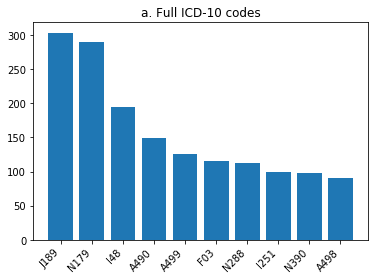

** GC category: 1-SEPTICEMIA BIGRAMS of ICD-10 codes**
[('I48_J189', 29), ('J189_J80', 26), ('N179_N189', 26), ('I251_I48', 25), ('J189_N179', 24), ('F03_J189', 14), ('I48_J449', 14), ('N179_N390', 14), ('J80_N179', 13), ('I48_J440', 13)]


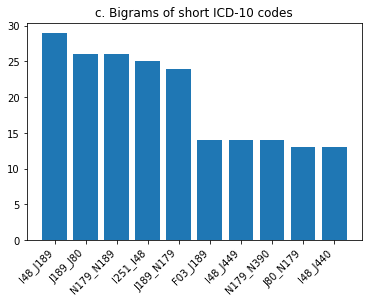

** GC category: 2-HEART FAILURE SHORT ICD-10 codes**
[('J449', 194), ('J189', 139), ('F03', 133), ('N189', 133), ('N179', 118), ('I48', 111), ('N19', 74), ('N185', 68), ('E149', 63), ('N288', 55)]


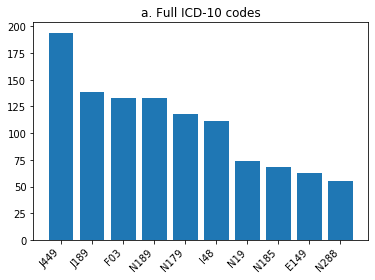

** GC category: 2-HEART FAILURE BIGRAMS of ICD-10 codes**
[('N179_N189', 30), ('I48_J449', 13), ('I48_I64', 11), ('F03_J449', 9), ('J189_N179', 9), ('E668_G473', 8), ('F03_J189', 7), ('J449_N189', 7), ('F03_I48', 7), ('I48_I634', 6)]


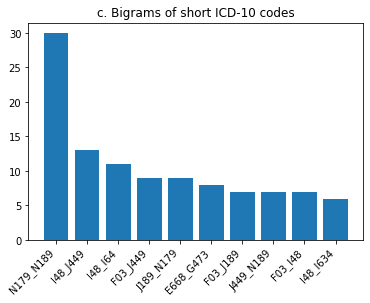

** GC category: 3-ILL-DEFINED CANCER SHORT ICD-10 codes**
[('C787', 226), ('C780', 199), ('C795', 151), ('C798', 129), ('J449', 117), ('I48', 103), ('C793', 92), ('C786', 79), ('N179', 73), ('J189', 70)]


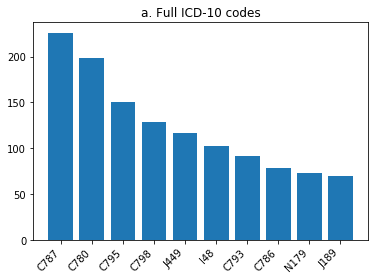

** GC category: 3-ILL-DEFINED CANCER BIGRAMS of ICD-10 codes**
[('C780_C787', 61), ('C787_C795', 38), ('C787_C788', 27), ('C795_C798', 23), ('C780_C798', 22), ('C780_C795', 19), ('C780_C793', 17), ('I48_J449', 16), ('C787_C793', 16), ('C793_C795', 15)]


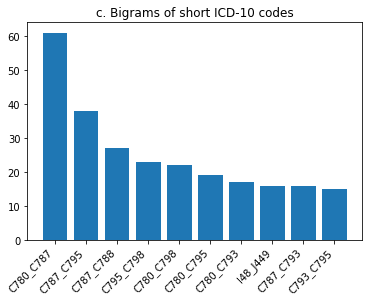

** GC category: 6-ILL-DEFINED CARDIOVASCULAR SHORT ICD-10 codes**
[('I48', 411), ('E785', 230), ('J449', 224), ('F019', 206), ('E149', 176), ('F03', 151), ('G931', 110), ('E119', 105), ('E669', 103), ('G309', 86)]


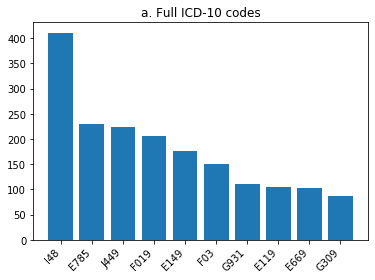

** GC category: 6-ILL-DEFINED CARDIOVASCULAR BIGRAMS of ICD-10 codes**
[('E149_E785', 26), ('F019_I48', 25), ('E785_F019', 24), ('I48_J449', 23), ('F03_I48', 23), ('E149_E669', 16), ('E119_E785', 16), ('E785_I48', 15), ('E669_E785', 12), ('E785_J449', 12)]


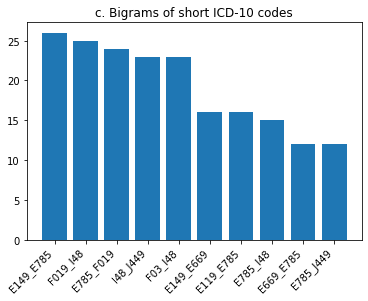

In [47]:
%store -r gc_label_dict

for i in [1, 2, 3, 6]:
    cat_recs = ds.loc[ds['gc_cat']== i, ['clean_mc']]
    mc_list = [a for b in cat_recs['clean_mc'] for a in ast.literal_eval(b)]
    print('** GC category: ' + gc_label_dict.get(i).upper() + ' SHORT ICD-10 codes**')
    bow_simple = Counter(mc_list)
    bow10 = bow_simple.most_common(10)
    print(bow10)
    bow10df = pd.DataFrame(bow10, columns=['Code', 'Count'])
    plt.bar(bow10df['Code'], bow10df['Count'])
    plt.title('a. Full ICD-10 codes')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    cat_recs3 = ds.loc[ds['gc_cat']== i, ['all_bigrams']]
    mc_bi = [a for b in cat_recs3['all_bigrams'] for a in ast.literal_eval(b)]
    print('** GC category: ' + gc_label_dict.get(i).upper() + ' BIGRAMS of ICD-10 codes**')
    bow_bi = Counter(mc_bi)
    bow_bi10 = bow_bi.most_common(10)
    print(bow_bi10)
    bow_bi10df = pd.DataFrame(bow_bi10, columns=['Bigram', 'Count'])
    plt.bar(bow_bi10df['Bigram'], bow_bi10df['Count'])
    plt.title('c. Bigrams of short ICD-10 codes')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [48]:
ds.to_csv('Y:/DQSS/Death/MBG/py/capstone2/data/d1619_clean_forLDA.csv')

In [51]:
%store -r gc_all

len(gc_all)

1974

**Next section: 4_Latent Dirichlet Allocation**